# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from pandas.core.frame import DataFrame
import math
import os
torch.manual_seed(0)

# Config

In [3]:
class Config():
  def __init__(self):
    super().__init__()

  # plit input, output config
    self.split_step = 24
    self.split_in_length = 24 * 7
    self.split_out_length = 24
    self.train_val_size = [250, 118]
    self.src_num_locs = 11
    self.tar_num_locs = 4
    
  # data config
    self.use_features = ['PM2.5', 'temperature', 'humidity', 'hsin', 'hcos', 'day', 'month', 'season']
    self.feature_in = len(self.use_features)
    self.feature_out = 1

  # cnn_fnn_hybird_layer config
    # cnn config
    self.in_size_cnn = self.feature_in
    self.hidden_size_cnn = 300
    self.num_layer_cnn = 2
    # fnn config
    self.in_feature_fnn = 1
    self.out_feature_fnn = 100
    #hybird_feature config
    self.in_feature_linear1 = self.hidden_size_cnn + self.out_feature_fnn
    self.out_feature_linear1 = 200
    self.in_feature_linear2 = self.out_feature_linear1
    self.out_feature_linear2 = 200

  # attention_layer config
    self.in_feature_linear3 = self.out_feature_linear2
    self.out_feature_linear3 = 1

  # prediction_layer config
    self.in_feature_linear4 = self.out_feature_linear2
    self.out_feature_linear4 = 24

  # training config
    self.batch_size = 64
    self.n_epochs = 20
    self.device = 'gpu'
    self.loss_func = 'RMSE'
  
    self.mean = torch.tensor([0.55, 8.8, 9.05, 0, 0, 0, 0, 0])
    self.std = torch.tensor([269.45, 37.11, 90.95, 1, 1, 31, 12, 4])
config = Config()

# Preprocessing Data

In [4]:
class Reading_Raw_Data:
  def __init__(self, path_src_locs: str, path_tar_locs: str, path_src_data: str, path_tar_data=''):
    self.src_data = self.read_data(path_src_data)
    self.src_locs = self.read_locs(path_src_locs, self.src_data.keys())

    if path_tar_data != '': 
      self.tar_data = self.read_data(path_tar_data)
      self.tar_locs = self.read_locs(path_tar_locs, self.tar_data.keys())
    else:
      self.tar_data = None
      self.tar_locs = self.read_locs(path_tar_locs)

  def get(self):
    return self.src_data, self.src_locs, self.tar_data, self.tar_locs

  def read_data(self, dir_path: str):
    data = {}
    for name in os.listdir(dir_path):
        data_pd = pd.read_csv(dir_path + name)
        limit = len(data_pd)

        if len(data_pd['PM2.5'][data_pd['PM2.5'].isna()]) >= limit / 2: continue
        if len(data_pd['temperature'][data_pd['temperature'].isna()]) >= limit / 2: continue
        if len(data_pd['humidity'][data_pd['humidity'].isna()]) >= limit / 2: continue

        hour, hsin, hcos, day, month, season, year = self.extractTimestamps(data_pd['timestamp'])
        data.update({
            name[0: -4]:
            {
              'PM2.5': data_pd['PM2.5'],
              'temperature': data_pd['temperature'],
              'humidity': data_pd['humidity'],
              'hour': hour,
              'hsin': hsin,
              'hcos': hcos,
              'day': day,
              'month': month,
              'season': season
            }
        })
    return data

  def read_locs(self, dir_path: str, use_locs=[]):
    locs_pd = pd.read_csv(dir_path)
    locs_dict = {}
    longitude = []
    latitude = []

    for i in range(len(locs_pd)):
      locs_dict.update({locs_pd['station'][i] : [locs_pd['longitude'][i], locs_pd['latitude'][i]]})

    if not use_locs: use_locs = list(locs_pd['station'])

    res = {}
    for loc in use_locs:
      res.update({loc : locs_dict[loc]})

    return res

  def extractDate(self, timestamp: DataFrame):
    tmp = datetime.strptime(timestamp, '%d/%m/%Y %H:%M')
    return tmp.hour, tmp.day, tmp.month, tmp.year

  def extractTimestamps(self, timestamps: DataFrame):
    hour, hsin, hcos, day, month, season, year = [], [], [], [], [], [], []
    for timestamp in timestamps:
      h, d, m, y = self.extractDate(timestamp)
      hour.append(h)
      hsin.append(math.sin(2*math.pi*h/24))
      hcos.append(math.cos(2*math.pi*h/24))
      day.append(d)
      month.append(m)
      season.append(m / 4)
      year.append(y)
    return hour, hsin, hcos, day, month, season, year
  
  def show(self, data: list):
    plt.plot(data)
    plt.show()

raw_data = Reading_Raw_Data('/content/drive/Shareddrives/air-team/data_spm/Public/Train/location.csv',
                            '/content/drive/Shareddrives/air-team/data_spm/Public/TestA/location.csv',
                            '/content/drive/Shareddrives/air-team/data_spm/Public/Train/input/',
                            '/content/drive/Shareddrives/air-team/data_spm/Public/Train/output/')

print(raw_data.tar_locs.keys())
print(raw_data.tar_locs.values())
print()
print(raw_data.tar_data.keys())
print(raw_data.tar_data['S0000182-Truong THCS Trung Hoa'].keys())
print(raw_data.tar_data['S0000182-Truong THCS Trung Hoa']['PM2.5'].shape)
print()
print(raw_data.src_locs.keys())
print(raw_data.src_locs.values())
print()
print(raw_data.src_data.keys())
print(raw_data.src_data['S0000137-Ngoc Khanh'].keys())
print(raw_data.src_data['S0000137-Ngoc Khanh']['PM2.5'].shape)

dict_keys(['S0000328-Luong The Vinh', 'S0000367-To Hieu', 'S0000182-Truong THCS Trung Hoa', 'S0000339-Kim Ma'])
dict_values([[105.78408, 20.99687], [105.77808, 20.96717], [105.798926, 21.014074], [105.824145, 21.031718]])

dict_keys(['S0000328-Luong The Vinh', 'S0000367-To Hieu', 'S0000182-Truong THCS Trung Hoa', 'S0000339-Kim Ma'])
dict_keys(['PM2.5', 'temperature', 'humidity', 'hour', 'hsin', 'hcos', 'day', 'month', 'season'])
(9000,)

dict_keys(['S0000370-Ba Trieu', 'S0000171-GENESIS School', 'S0000229-Quan Hoa', 'S0000264-FDS - Ton That Thuyet', 'S0000310-Hang Trong', 'S0000153-Truong Tieu hoc Tran Quoc Toan', 'S0000541-Tran Quang Khai', 'S0000210-Truong THCS Yen So', 'S0000137-Ngoc Khanh', 'S0000143-Thu vien - DHQG Ha Noi', 'S0000238-He thong lien cap Lomonoxop - Mam non'])
dict_values([[105.848945, 21.011621], [105.801322, 21.050128], [105.805607, 21.039073], [105.785088, 21.026053], [105.8506845, 21.0287174], [105.850535, 21.026903], [105.859016, 21.025092], [105.679643, 21.0446

In [5]:
class Solving_Missing_Data:
  def __init__(self, data):
    src_data, self.src_locs, tar_data, self.tar_locs = data.get()

    self.src_data = self.fill_missing_data(src_data)
    self.tar_data = None
    if data.tar_data != None: 
      self.tar_data = self.fill_missing_data(tar_data)

  def get(self):
    return self.src_data, self.src_locs, self.tar_data, self.tar_locs

  def fill_missing_data(self, data: dict):
    # data: 9000, num_locs, num_feas
    for loc in data.keys():
      for feature in data[loc].keys():
        if feature in ('PM2.5', 'temperature', 'humidity'):
          data[loc][feature] =data[loc][feature].interpolate(option="spline").bfill()
    return data

full_data = Solving_Missing_Data(raw_data)

In [6]:
# Concatenate and normalize data
class Merger_Norm_Data:
  def __init__(self, config, data):
    self.mean = config.mean
    self.std = config.std
    self.use_features = config.use_features

    src_data, src_locs, tar_data, tar_locs = data.get()

    src_locs = self.concatenate_locs(src_locs)
    tar_locs = self.concatenate_locs(tar_locs)

    self.distance = self.compute_distance(src_locs, tar_locs)
    self.src_data = self.concatenate_features(src_data)
    self.tar_data = None
    if tar_data != None:
      self.tar_data = self.concatenate_features(tar_data)[:, :, 0]

  def get(self):
    return self.src_data, self.tar_data, self.distance

  def concatenate_features(self, data: dict):
    concatenated_data = []
    for loc in data.keys():
      list_features = []
      
      for feature in self.use_features:
        list_features.append(torch.tensor(data[loc][feature]))

      concatenated_data.append(torch.stack(list_features, dim = 1))
    concatenated_data = torch.stack(concatenated_data, dim=1)
    return self.normalize(concatenated_data)

  def concatenate_locs(self, locs: dict):
    coords = []
    for key in locs.keys():
      coords.append(torch.tensor(locs[key]))
    locs = torch.stack(coords, dim = 0)
    return locs

  def compute_distance(self, src_locs: torch.Tensor, tar_locs: torch.Tensor):
    distance = []

    for tar_loc in tar_locs:
      tar_loc = tar_loc.view(1, -1)
      sum = torch.sum((src_locs - tar_loc)**2, 1)
      dist = torch.sqrt(sum)
      normalized_dist = dist / torch.sum(dist)
      distance.append(normalized_dist)

    distance = torch.stack(distance, 0)
    return distance

  def normalize(self, data: torch.tensor):
    return (data - self.mean) / self.std

mergered_normalized_data = Merger_Norm_Data(config, full_data)

print('use features:', config.use_features)

print('distance:', mergered_normalized_data.distance.shape)
print('src_data:', mergered_normalized_data.src_data.shape)
print('tar_data:', mergered_normalized_data.tar_data.shape)

use features: ['PM2.5', 'temperature', 'humidity', 'hsin', 'hcos', 'day', 'month', 'season']
distance: torch.Size([4, 11])
src_data: torch.Size([9000, 11, 8])
tar_data: torch.Size([9000, 4])


In [7]:
class Spliting_Data:
  def __init__(self, config, data):
    self.split_step = config.split_step
    self.split_in_length = config.split_in_length
    self.split_out_length = config.split_out_length
    self.batch_size = config.batch_size
    self.train_val_size = config.train_val_size

    src_data, tar_data, self.distance = data.get()
    src_data = self.split_src_data(src_data)
    tar_data = self.split_tar_data(tar_data)

    self.train_set, self.val_set = self.split_train_val(src_data, tar_data)
    self.id_train_loader, self.id_val_loader = self.id_split_batch(self.train_set, self.val_set)

  def split_src_data(self, src_data: torch.tensor):
    res = []

    for i in range(0, len(src_data), self.split_step):
      end_id = i + self.split_in_length
      if end_id + self.split_out_length > len(src_data): break
      res.append(src_data[i:end_id].transpose(0, 1).unsqueeze(0))

    return torch.cat(res)

  def split_tar_data(self, tar_data: torch.tensor):
    res = []

    for i in range(self.split_in_length, len(tar_data), self.split_step):
      end_id = i + self.split_out_length
      if end_id > len(tar_data): break
      res.append(tar_data[i:end_id].transpose(0, 1).unsqueeze(0))

    return torch.cat(res)
  
  def split_train_val(self, src_data: torch.Tensor, tar_data: torch.Tensor):
    data_set = TensorDataset(src_data, tar_data)
    train_set, val_set = random_split(data_set, self.train_val_size)

    return train_set, val_set

  def id_split_batch(self, train_set: TensorDataset, val_set: TensorDataset):
    id_train_set = torch.arange(0, len(train_set))
    id_val_set = torch.arange(0, len(val_set))

    id_train_loader = DataLoader(id_train_set, batch_size=self.batch_size, shuffle=True)
    id_val_loader = DataLoader(id_val_set, batch_size=self.batch_size, shuffle=True)

    return id_train_loader, id_val_loader

  def get_in_out(self, id: torch.Tensor, tar_loc: int, name: str):
    if name == 'train': data_set = self.train_set
    else: data_set = self.val_set
    
    static_data = self.distance[tar_loc]
    temporal_data, output = data_set[list(id)]
    
    input = (temporal_data.float(), static_data.float())
    return input, output[:, tar_loc].float()

splitted_data = Spliting_Data(config, mergered_normalized_data)

print('use features:', config.use_features)
print('distance:', splitted_data.distance.shape)
print('train_loader:', len(splitted_data.id_train_loader))  
print('val_loader:', len(splitted_data.id_val_loader))

use features: ['PM2.5', 'temperature', 'humidity', 'hsin', 'hcos', 'day', 'month', 'season']
distance: torch.Size([4, 11])
train_loader: 4
val_loader: 2


# Layer

In [8]:
class FNN_RNN_Hybrid_Layers(nn.Module):
  '''
    Input:  temporal_data: batch_size, 11, n_sequences, n_features
            static_data: 11
    Output: batch_size, 11, 400
  '''
  def __init__(self, config):
    super().__init__()
    
    self.RNN = nn.LSTM(input_size=config.in_size_cnn, 
                       hidden_size=config.hidden_size_cnn,
                       num_layers=config.num_layer_cnn,
                       batch_first=True) 
    self.FNN = nn.Linear(in_features=config.in_feature_fnn, 
                         out_features=config.out_feature_fnn, 
                         bias=True)
    self.hybird_feature = nn.Sequential(
          nn.Linear(config.in_feature_linear1, config.out_feature_linear1, bias=True),
          nn.ReLU(),
          nn.Linear(config.in_feature_linear2, config.out_feature_linear2, bias=True),
          nn.ReLU()
    )

  def forward(self, input):
    temporal_data, static_data = input
    batch_size, n_locs, n_sequences, n_features = temporal_data.shape
    
    temporal_data =  temporal_data.view(-1, n_sequences, n_features)
    _, (h_state, c_state) = self.RNN(temporal_data)
    # lấy 1 output cuối
    temporal_output = h_state[-1].view(batch_size, n_locs, -1)

    static_data = static_data[None, :, None]
    static_output = F.relu(self.FNN(static_data))
    static_output = static_output.repeat_interleave(batch_size, dim = 0)

    output = self.hybird_feature(torch.cat((temporal_output, static_output), dim=2))
    return output

In [9]:
class Attention_Layer(nn.Module):
    '''
      Input: (batch_size, 11, 400)
      Output: (batch_size, 400) 
    '''
    def __init__(self, config):
      super().__init__()
      self.attention = nn.Linear(config.in_feature_linear3, config.out_feature_linear3, bias=True)

    def forward(self, input):
      value = self.attention(input)
      score = F.softmax(value, 1)
      output = torch.sum(input * score, 1)
      return output

In [10]:
class Prediction_Layer(nn.Module):
  '''
  Input: (batch_size, 400)
  Output: (batch_size, 24) 
  '''
  def __init__(self, config):
    super().__init__()
    self.prediction = nn.Linear(config.in_feature_linear4, config.out_feature_linear4, bias=True)
  def forward(self, input):
    output = self.prediction(input)
    return output

# Model

In [11]:
class AQF_Model(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.mean = config.mean
    self.std = config.std
    self.layer1 = FNN_RNN_Hybrid_Layers(config)
    self.layer2 = Attention_Layer(config)
    self.layer3 = Prediction_Layer(config)
  
  def forward(self, input):
    src_features = self.layer1(input)
    # print(src_features.shape, 'layer 1')
    tar_features = self.layer2(src_features)
    # print(tar_features.shape, 'layer2')
    output = self.layer3(tar_features)
    # print(output.shape, 'layer3')
    return output
  
  def predict(self, input):
    output = self.forward(input)
    output = output * self.std[0] + self.mean[0]
    return output

# Loss function

In [12]:
class MAPELoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, output, predict):
    mape = (output - predict) / output
    mape = torch.sum(mape.abs(), 1) / output.shape[1]
    mape = torch.sum(mape) / output.shape[0]
    return mape

class RMSELoss(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.std = config.std
    self.mean = config.mean
  def forward(self, output, predict):
    output = output * self.std[0] + self.mean[0]
    predict = predict * self.std[0] + self.mean[0]

    rmse = (output - predict) ** 2
    rmse = torch.sqrt(torch.sum(rmse, 1) / output.shape[1])
    rmse = torch.sum(rmse) / output.shape[0]
    return rmse

class MDAPELoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, output, predict):
    mdape = (output - predict) / output
    mdape = torch.median(mdape.abs(), 1).values
    mdape = torch.sum(mdape) / output.shape[0]
    return mdape

# Train

In [13]:
def show_result(train_error, val_error, loss_func):
  plt.plot(train_error, label='train_loss')
  plt.plot(val_error, label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel(loss_func)
  plt.legend()
  plt.show()

In [14]:
def training_loop(model, data, config):
  print('training')
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)
  
  if config.loss_func == 'RMSE': loss_fn = RMSELoss(config)
  elif config.loss_func == 'MDAPE': loss_fn = MDAPELoss()
  elif config.loss_func == 'MAPE': loss_fn = MAPELoss()
  else: loss_fn = nn.MSELoss()
  
  id_train_loader = data.id_train_loader
  id_val_loader = data.id_val_loader 

  if config.device == 'gpu': model = model.to('cuda')
  
  train_error = []
  val_error = []
  
  for epoch in range(0, config.n_epochs):
    train_loss = 0.0
    
    for id in id_train_loader:
      sum = 0.0
    
      for tar_loc in range(config.tar_num_locs): 
        input, output = data.get_in_out(id, tar_loc, 'train')

        if config.device == 'gpu':
          input = [input[0].to('cuda'), input[1].to('cuda')]
          output = output.to('cuda')

        predict = model(input)
        loss = loss_fn(output, predict)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum += loss.item()

      train_loss += sum / (config.tar_num_locs)
    train_loss /= len(id_train_loader)

    val_loss = 0.0
    with torch.no_grad():
      for id in id_val_loader:

        tar_loc =  config.tar_num_locs - 1
        input, output = data.get_in_out(id, tar_loc, 'val')
          
        if config.device == 'gpu':
          input = [input[0].to('cuda'), input[1].to('cuda')]
          output = output.to('cuda')

        predict = model(input)
        loss = loss_fn(output, predict)
        val_loss += loss.item()

    val_loss /= len(id_val_loader)
    scheduler.step(val_loss)
    
    print('Epoch {}, Training loss {}, Val Loss {}'.format(epoch, train_loss, val_loss))
    train_error.append(train_loss)
    val_error.append(val_loss)
  show_result(train_error, val_error, config.loss_func)

training
Epoch 0, Training loss 38.9213764667511, Val Loss 31.582780838012695
Epoch 1, Training loss 34.752554178237915, Val Loss 29.527952194213867
Epoch 2, Training loss 28.68701171875, Val Loss 24.257481575012207
Epoch 3, Training loss 26.399375319480896, Val Loss 23.98935031890869
Epoch 4, Training loss 24.828898668289185, Val Loss 22.78689479827881
Epoch 5, Training loss 24.396942496299744, Val Loss 22.832802772521973
Epoch 6, Training loss 24.01692759990692, Val Loss 23.12187671661377
Epoch 7, Training loss 23.97322928905487, Val Loss 22.74247455596924
Epoch 8, Training loss 23.951140642166138, Val Loss 23.13138484954834
Epoch 9, Training loss 23.809712529182434, Val Loss 22.772067070007324
Epoch 10, Training loss 23.742804050445557, Val Loss 22.568123817443848
Epoch 11, Training loss 23.73632311820984, Val Loss 22.480810165405273
Epoch 12, Training loss 24.877915143966675, Val Loss 23.624217987060547
Epoch 13, Training loss 26.163864016532898, Val Loss 23.600616455078125
Epoch 1

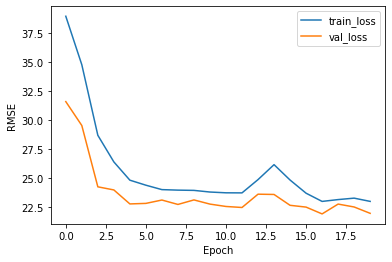

In [15]:
model = AQF_Model(config)
training_loop(model, splitted_data, config)

# Predict

In [ ]:
save_folder = '/content/prediction'
os.mkdir(save_folder)

dir_path = '/content/drive/Shareddrives/air-team/data_spm/TestA/input/'
for dir_idx in range(0, 100):
  print('folder {} :'.format(dir_idx))
  raw_data = Reading_Raw_Data('/content/drive/Shareddrives/air-team/data_spm/Train/location.csv',
                            '/content/drive/Shareddrives/air-team/data_spm/TestA/location.csv',
                            dir_path + '/' + str(dir_idx + 1) + '/') 
  full_data = Solving_Missing_Data(raw_data)
  mergered_normalized_data = Merger_Norm_Data(config, full_data)
  
  src_data = mergered_normalized_data.src_data
  src_data = src_data.transpose(0, 1).unsqueeze(0)
  distance = mergered_normalized_data.distance

  if config.device == 'gpu':
    src_data = src_data.to('cuda')
    distance = distance.to('cuda')

  cur_folder = save_folder + '/' + str(dir_idx + 1)
  os.mkdir(cur_folder)
  for tar_loc in range(config.tar_num_locs):
    input = (src_data.float(), distance[tar_loc].float())
    output = model.predict(input).view(-1)
    df = pd.DataFrame.from_dict({"PM2.5": output.tolist()})
    df.to_csv(os.path.join(cur_folder + '/', f"res_{dir_idx + 1}_{tar_loc + 1}.csv"), index=False)

In [ ]:
!zip -r /content/prediction.zip /content/prediction

In [ ]:
!rm -rf prediction